In [65]:
# !pip install chromadb langchain_openai opensearch-py
# !pip install langgraph

In [1]:
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatOllama
from langchain_experimental.llms.ollama_functions import OllamaFunctions
import dotenv
import langgraph
import os 
dotenv.load_dotenv('.env')
# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
# os.environ['OPENAI_API_KEY'] = 'sk-'
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = ''

### Agent state
We will defined a graph.

A state object that it passes around to each node.

Our state will be a list of messages.

Each node in our graph will append to it.

In [10]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Nodes and Edges
We can lay out an agentic RAG graph like this:

The state is a set of messages
Each node will update (append to) state
Conditional edges decide which node to visit next
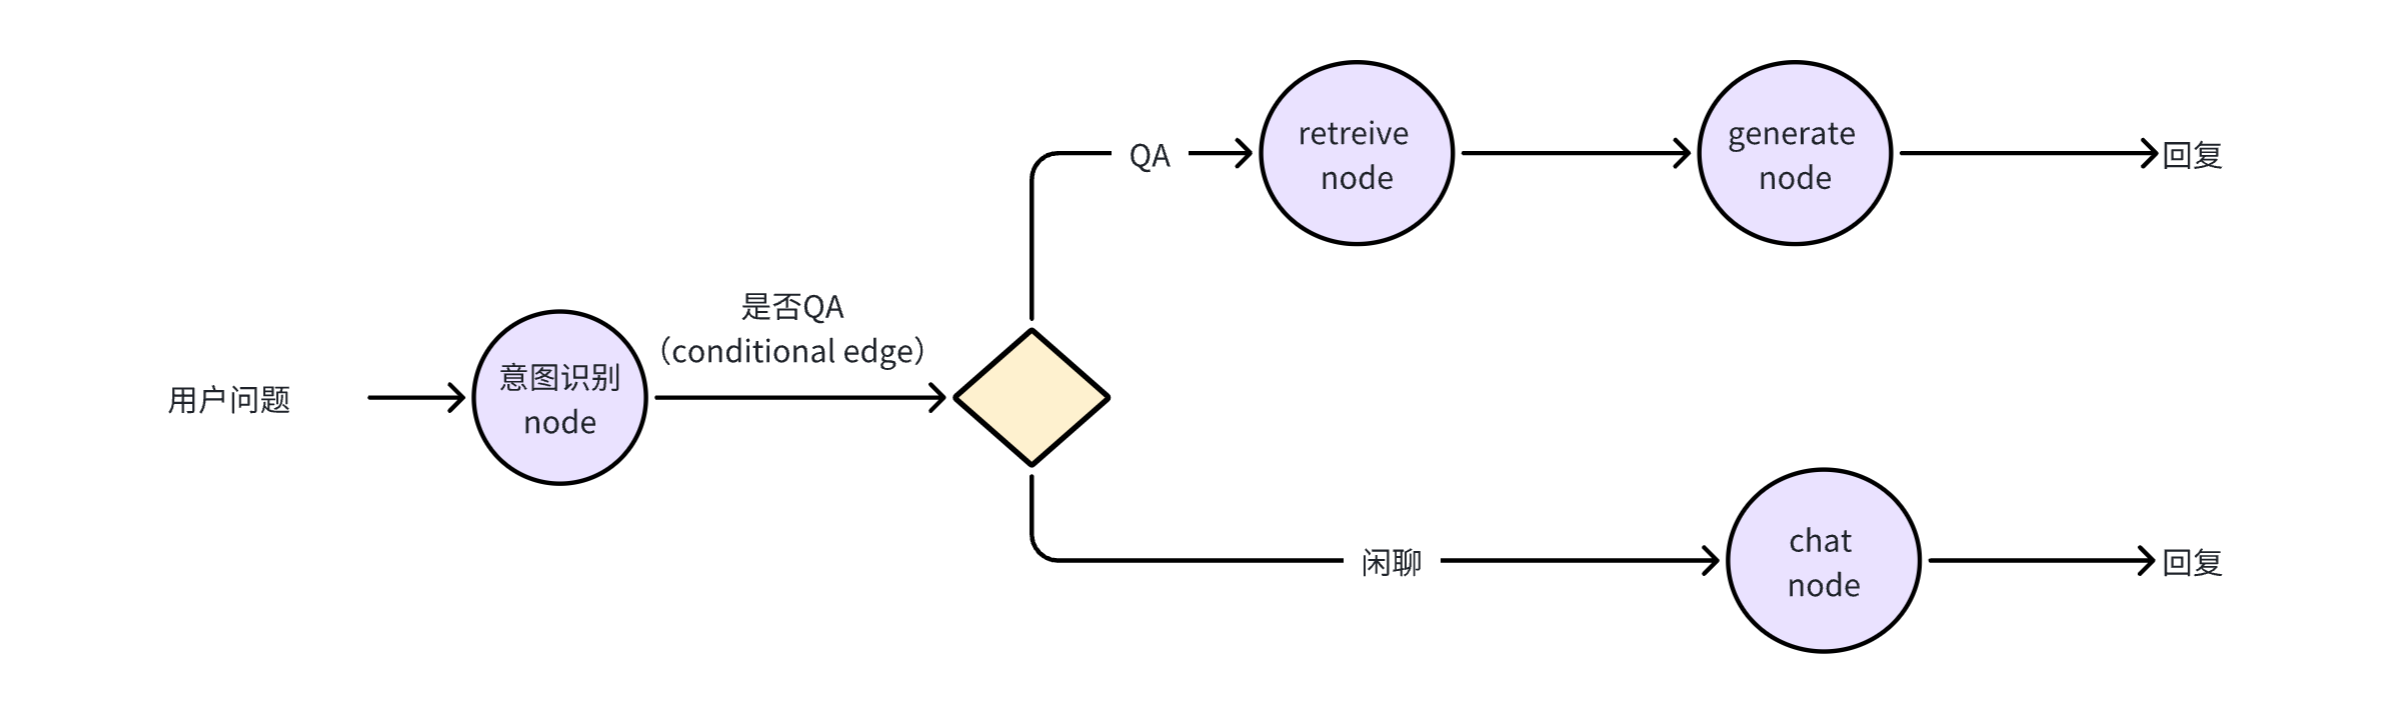

### 定义一个retrieve工具，用于从知识库种召回知识

- use a remote opensearch service

In [3]:
from opensearchpy import OpenSearch,helpers,RequestsHttpConnection
from langchain.schema import BaseRetriever
from langchain.schema import Document
import time
import math,hashlib
import logging
from typing import List,Any
AOS_ENDPOINT = os.environ.get('AOS_ENDPOINT')
AOS_USERNAME = os.environ.get('AOS_USERNAME','admin')
AOS_PASSWORD = os.environ.get('AOS_PASSWORD','admin')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
CHANNEL_RET_CNT = 10

BM25_QD_THRESHOLD_HARD_REFUSE = float(os.environ.get('bm25_qd_threshold_hard',15.0))
BM25_QD_THRESHOLD_SOFT_REFUSE = float(os.environ.get('bm25_qd_threshold_soft',20.0))
KNN_QQ_THRESHOLD_HARD_REFUSE = float(os.environ.get('knn_qq_threshold_hard',0.6))
KNN_QQ_THRESHOLD_SOFT_REFUSE = float(os.environ.get('knn_qq_threshold_soft',0.8))
KNN_QD_THRESHOLD_HARD_REFUSE = float(os.environ.get('knn_qd_threshold_hard',0.6))
KNN_QD_THRESHOLD_SOFT_REFUSE = float(os.environ.get('knn_qd_threshold_soft',0.8))
RERANK_THRESHOLD = float(os.environ.get('rerank_threshold_soft',-2))
WEBSEARCH_THRESHOLD = float(os.environ.get('websearch_threshold_soft',1))
CROSS_MODEL_ENDPOINT = os.environ.get('cross_model_endpoint',None)
KNN_QUICK_PEFETCH_THRESHOLD = float(os.environ.get('knn_quick_prefetch_threshold',0.95))
EMB_MODEL_ENDPOINT=os.environ.get('EMB_MODEL_ENDPOINT','OPENAI')
INTENTION_LIST = os.environ.get('intention_list', "")

TOP_K = int(os.environ.get('TOP_K',4))
NEIGHBORS = int(os.environ.get('neighbors',0))

In [5]:
EMB_MODEL_ENDPOINT

'OPENAI'

In [6]:
import requests,json
def get_vector_by_sm_endpoint(text_arrs,  endpoint_name):
    embeddings = []
    if endpoint_name == 'OPENAI':
        logger.info("get_embedding with OPENAI")
        from langchain_openai import OpenAIEmbeddings
        embeddings_model = OpenAIEmbeddings(openai_api_key=os.environ.get('OPENAI_API_KEY'),model='text-embedding-3-large',dimensions=1024)
        embeddings = embeddings_model.embed_documents(text_arrs)
    else:
        logger.info(f"get_embedding with {endpoint_name}")
        headers = {"Content-Type": "application/json"}
        data = {"data": {"inputs": text_arrs}}
        try: 
            response = requests.post(endpoint_name,headers=headers,data=json.dumps(data,ensure_ascii=False))
            print(response)
            if response.status_code == 200:
                embeddings = response.json()['embeddings']
        except Exception as e:
            logger.error(str(e)) 
    
    return embeddings

In [7]:
def search_using_aos_knn(client, q_embedding, index, size=10):

    #Note: 查询时无需指定排序方式，最临近的向量分数越高，做过归一化(0.0~1.0)
    #精准Knn的查询语法参考 https://opensearch.org/docs/latest/search-plugins/knn/knn-score-script/
    #模糊Knn的查询语法参考 https://opensearch.org/docs/latest/search-plugins/knn/approximate-knn/
    #这里采用的是模糊查询
    query = {
        "size": size,
        "query": {
            "knn": {
                "embedding": {
                    "vector": q_embedding,
                    "k": size
                }
            }
        }
    }
    opensearch_knn_respose = []
    query_response = client.search(
        body=query,
        index=index
    )
    opensearch_knn_respose = [{'idx':item['_source'].get('idx',1),'doc_category':item['_source']['doc_category'],'doc_classify':item['_source'].get('doc_classify'),'doc_title':item['_source']['doc_title'],'id':item['_id'],'doc':item['_source']['content'],"doc_type":item["_source"]["doc_type"],"score":item["_score"],'doc_author': item['_source']['doc_author'], 'doc_meta': item['_source'].get('doc_meta','')}  for item in query_response["hits"]["hits"]]
    return opensearch_knn_respose
    


def aos_search(client, index_name, field, query_term, exactly_match=False, size=10):
    """
    search opensearch with query.
    :param host: AOS endpoint
    :param index_name: Target Index Name
    :param field: search field
    :param query_term: query term
    :return: aos response json
    """
    if not isinstance(client, OpenSearch):   
        client = OpenSearch(
            hosts=[{'host': client, 'port': 9200}],
            http_auth = (AOS_USERNAME, AOS_PASSWORD),
            # use_ssl=True,
            verify_certs=False,
            connection_class=RequestsHttpConnection
        )
    query = None
    if exactly_match:
        query =  {
            "query" : {
                "match_phrase":{
                    "doc": {
                        "query": query_term,
                        "analyzer": "ik_smart"
                      }
                }
            }
        }
    else:
        query = {
            "size": size,
            "query": {
                "bool": {
                    "should": [{
                            "bool": {
                                "must": [{
                                        "term": {
                                            "doc_type": "Question"
                                        }
                                    },
                                    {
                                        "match": {
                                            "content": query_term
                                        }
                                    }
                                ]
                            }
                        },
                        {
                            "bool": {
                                "must": [{
                                        "term": {
                                            "doc_type": "Paragraph"
                                        }
                                    },
                                    {
                                        "match": {
                                            "content": query_term
                                        }
                                    }
                                ]
                            }
                        }
                    ]
                }
            },
            "sort": [{
                "_score": {
                    "order": "desc"
                }
            }]
        }
    query_response = client.search(
        body=query,
        index=index_name
    )

    if exactly_match:
        result_arr = [ {'idx':item['_source'].get('idx',0),'doc_category':item['_source']['doc_category'],'doc_classify':item['_source'].get('doc_classify'),'doc_title':item['_source']['doc_title'],'id':item['_id'],'doc': item['_source']['content'], 'doc_type': item['_source']['doc_type'], 'score': item['_score'],'doc_author': item['_source']['doc_author'], 'doc_meta': item['_source'].get('doc_meta','')} for item in query_response["hits"]["hits"]]
    else:
        result_arr = [ {'idx':item['_source'].get('idx',0),'doc_category':item['_source']['doc_category'],'doc_classify':item['_source'].get('doc_classify'),'doc_title':item['_source']['doc_title'],'id':item['_id'],'doc':item['_source']['content'], 'doc_type': item['_source']['doc_type'], 'score': item['_score'],'doc_author': item['_source']['doc_author'], 'doc_meta': item['_source'].get('doc_meta','')} for item in query_response["hits"]["hits"]]
    return result_arr

In [8]:
class CustomDocRetriever(BaseRetriever):
    embedding_model_endpoint :str
    aos_endpoint: str
    aos_index: str
        
    class Config:
        """Configuration for this pydantic object."""
        arbitrary_types_allowed = True
        
    @classmethod
    def from_endpoints(cls,embedding_model_endpoint:str, aos_endpoint:str, aos_index:str,):
        return cls(embedding_model_endpoint=embedding_model_endpoint,
                  aos_endpoint=aos_endpoint,
                  aos_index=aos_index)
    
    #this is for standard langchain interface
    def get_relevant_documents(self, query_input: str) -> List[Document]:
        recall_knowledge = None
        recall_knowledge,_,_= self.get_relevant_documents_custom(query_input) 
        top_k_results = []
        for item in recall_knowledge:
            top_k_results.append(Document(page_content=item.get('doc')))
        return top_k_results
       
     ## kkn前置检索FAQ,，如果query非常相似，则返回作为cache
    def knn_quick_prefetch(self,query_input: str) -> List[Any]:
        global KNN_QUICK_PEFETCH_THRESHOLD
        start = time.time()
        query_embedding = get_vector_by_sm_endpoint(query_input, self.embedding_model_endpoint)
        elpase_time = time.time() - start
        logger.info(f'knn_quick_prefetch, running time of get embeddings : {elpase_time:.3f}s')
        aos_client = OpenSearch(
                hosts=[{'host': self.aos_endpoint, 'port': 9200}],
                http_auth=(AOS_USERNAME, AOS_PASSWORD),
                # use_ssl=True,
                verify_certs=False,
                connection_class=RequestsHttpConnection
            )
        start = time.time()
        opensearch_knn_respose = search_using_aos_knn(aos_client,query_embedding[0], self.aos_index,size=3)
        elpase_time = time.time() - start
        logger.info(f'runing time of quick_knn_fetch : {elpase_time:.3f}s')
        filter_knn_result = [item for item in opensearch_knn_respose if (item['score'] > KNN_QUICK_PEFETCH_THRESHOLD and item['doc_type'] == 'Question')]
        if len(filter_knn_result) :
            filter_knn_result.sort(key=lambda x:x['score'])
        return filter_knn_result

    async def aget_relevant_documents(self, query: str) -> List[Document]:
        raise NotImplementedError
        
    def add_neighbours_doc(self,client,opensearch_respose):
        docs = []
        docs_dict = {}
        for item in opensearch_respose:
            ## only apply to 'Paragraph','Sentence' type file
            if item['doc_type'] in ['Paragraph','Sentence'] and ( 
                item['doc_title'].endswith('.wiki.json') or 
                item['doc_title'].endswith('.blog.json') or 
                item['doc_title'].endswith('.txt') or 
                item['doc_title'].endswith('.docx') or
                item['doc_title'].endswith('.pdf')) :
                #check if has duplicate content in Paragraph/Sentence types
                key = f"{item['doc_title']}-{item['doc_category']}-{item['idx']}"
                if key not in docs_dict:
                    docs_dict[key] = item['idx']
                    doc = self.search_paragraph_neighbours(client,item['idx'],item['doc_title'],item['doc_category'],item['doc_type'])
                    docs.append({ **item, "doc": doc } )
            else:
                docs.append(item)
        return docs

    def search_paragraph_neighbours(self,client, idx, doc_title,doc_category,doc_type):
        query ={
            "query":{
                "bool": {
                "must": [
                    {
                    "terms": {
                        "idx": [i for i in range(idx-NEIGHBORS,idx+NEIGHBORS+1)]
                    }
                    },
                    {
                    "terms": {
                        "doc_title": [doc_title]
                    }
                    },
                    {
                  "terms": {
                    "doc_category": [doc_category]
                    }
                    },
                    {
                    "terms": {
                        "doc_type": [doc_type]
                    }
                    }
                ]
                }
            }
        }
        query_response = client.search(
            body=query,
            index=self.aos_index
        )
         ## the 'Sentence' type has mappings sentence:content:idx = n:1:1, so need to filter out the duplicate idx
        idx_dict = {}
        doc = ''
        for item in query_response["hits"]["hits"]:
            key = item['_source']['idx']
            if key not in idx_dict:
                idx_dict[key]=key
                doc += item['_source']['content']+'\n'            
        return doc

    ## 调用排序模型
    def rerank(self,query_input: str, docs: List[Any],cross_model_endpoint):
        inputs = [query_input]*len(docs)
        response_model = sm_client.invoke_endpoint(
            EndpointName=cross_model_endpoint,
            Body=json.dumps(
                {
                    "inputs": inputs,
                    "docs": [item['doc'] for item in docs]
                }
            ),
            ContentType="application/json",
        )
        json_str = response_model['Body'].read().decode('utf8')
        json_obj = json.loads(json_str)
        scores = json_obj['scores']
        return scores if isinstance(scores, list) else [scores]
    
    def de_duplicate(self,docs):
        unique_ids = set()
        nodup = []
        for item in docs:
            doc_hash = hashlib.md5(str(item['doc']).encode('utf-8')).hexdigest()
            if doc_hash not in unique_ids:
                nodup.append(item)
                unique_ids.add(doc_hash)
        return nodup

    
    def get_websearch_documents(self, query_input: str) -> list:
        # 使用agent方式速度比较慢，直接改成调用search api
        all_docs = web_search(query=query_input)
        logger.info(f'all_docs:{all_docs}')
        recall_knowledge = [{'doc_title':item['title'],'doc':item['title']+'\n'+item['snippet'],
                             'doc_classify':'web_search','doc_type':'web_search','score':0.8,'doc_author':item['link']} for item in all_docs]
        return recall_knowledge
    
    def get_relevant_documents_custom(self, query_input: str):
        global BM25_QD_THRESHOLD_HARD_REFUSE, BM25_QD_THRESHOLD_SOFT_REFUSE
        global KNN_QQ_THRESHOLD_HARD_REFUSE, KNN_QQ_THRESHOLD_SOFT_REFUSE,WEBSEARCH_THRESHOLD
        global KNN_QD_THRESHOLD_HARD_REFUSE, KNN_QD_THRESHOLD_SOFT_REFUSE
        start = time.time()
        query_embedding = get_vector_by_sm_endpoint(query_input,  self.embedding_model_endpoint)
        elpase_time = time.time() - start
        logger.info(f'running time of get embeddings : {elpase_time:.3f}s')
        aos_client = OpenSearch(
                hosts=[{'host': self.aos_endpoint, 'port': 9200}],
                http_auth = (AOS_USERNAME,AOS_PASSWORD),
                use_ssl=True,
                verify_certs=False,
                connection_class=RequestsHttpConnection
            )
        start = time.time()
        opensearch_knn_respose = search_using_aos_knn(aos_client,query_embedding[0], self.aos_index,size=CHANNEL_RET_CNT)
        elpase_time = time.time() - start
        logger.info(f'runing time of opensearch_knn : {elpase_time}s seconds')
        
        # 4. get AOS invertedIndex recall
        start = time.time()
        opensearch_query_response = aos_search(aos_client, self.aos_index, "doc", query_input,size=CHANNEL_RET_CNT)
        # logger.info(opensearch_query_response)
        elpase_time = time.time() - start
        logger.info(f'runing time of opensearch_query : {elpase_time}s seconds')

        # 5. combine these two opensearch_knn_respose and opensearch_query_response
        def combine_recalls(opensearch_knn_respose, opensearch_query_response):
            '''
            filter knn_result if the result don't appear in filter_inverted_result
            '''
            def get_topk_items(opensearch_knn_respose, opensearch_query_response, topk=1):

                opensearch_knn_nodup = []
                unique_ids = set()
                for item in opensearch_knn_respose:
                    doc_hash = hashlib.md5(str(item['doc']).encode('utf-8')).hexdigest()
                    if doc_hash not in unique_ids:
                        opensearch_knn_nodup.append(item)
                        unique_ids.add(doc_hash)
                
                opensearch_bm25_nodup = []
                for item in opensearch_query_response:
                    doc_hash = hashlib.md5(str(item['doc']).encode('utf-8')).hexdigest()
                    if doc_hash not in unique_ids:
                        opensearch_bm25_nodup.append(item)
                        doc_hash = hashlib.md5(str(item['doc']).encode('utf-8')).hexdigest()
                        unique_ids.add(doc_hash)

                opensearch_knn_nodup.sort(key=lambda x: x['score'])
                opensearch_bm25_nodup.sort(key=lambda x: x['score'])
                
                half_topk = math.ceil(topk/2) 
    
                kg_combine_result = [ item for item in opensearch_knn_nodup[-1*half_topk:]]
                knn_kept_doc = [ item['id'] for item in opensearch_knn_nodup[-1*half_topk:] ]

                bm25_count = 0
                for item in opensearch_bm25_nodup[::-1]:
                    if item['id'] not in knn_kept_doc:
                        kg_combine_result.append(item)
                        bm25_count += 1
                    if bm25_count+len(knn_kept_doc) >= topk:
                        break
                ##继续填补不足的召回
                step_knn = 0
                step_bm25 = 0
                while topk - len(kg_combine_result)>0:
                    if len(opensearch_knn_nodup) > half_topk and len(opensearch_knn_nodup[-1*half_topk-1-step_knn:-1*half_topk-step_knn]) > 0:
                        kg_combine_result += [item for item in opensearch_knn_nodup[-1*half_topk-1-step_knn:-1*half_topk-step_knn]]
                        kg_combine_result.sort(key=lambda x: x['score'])
                        step_knn += 1
                    elif len(opensearch_bm25_nodup) > half_topk and len(opensearch_bm25_nodup[-1*half_topk-1-step_bm25:-1*half_topk-step_bm25]) >0:
                        kg_combine_result += [item for item in opensearch_bm25_nodup[-1*half_topk-1-step_bm25:-1*half_topk-step_bm25]]
                        step_bm25 += 1
                    else:
                        break

                return kg_combine_result
            
            ret_content = get_topk_items(opensearch_knn_respose, opensearch_query_response, TOP_K)
            logger.info(f'get_topk_items:{len(ret_content)}')
            return ret_content
        
        filter_knn_result = [ item for item in opensearch_knn_respose if (item['score'] > KNN_QQ_THRESHOLD_HARD_REFUSE and item['doc_type'] == 'Question') or 
                              (item['score'] > KNN_QD_THRESHOLD_HARD_REFUSE and item['doc_type'] == 'Paragraph') or
                              (item['score'] > KNN_QQ_THRESHOLD_HARD_REFUSE and item['doc_type'] == 'Sentence')]
        filter_inverted_result = [ item for item in opensearch_query_response if item['score'] > BM25_QD_THRESHOLD_HARD_REFUSE ]

        recall_knowledge = []
        ##是否使用rerank
        cross_model_endpoint = CROSS_MODEL_ENDPOINT
        if cross_model_endpoint:
            all_docs = filter_knn_result+filter_inverted_result

            ###to do 去重
            all_docs = self.de_duplicate(all_docs)
            if all_docs:
                scores = self.rerank(query_input, all_docs,sm_client,cross_model_endpoint)
                ##sort by scores
                sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=False)
                recall_knowledge = [{**all_docs[idx],'rank_score':scores[idx] } for idx in sorted_indices[-TOP_K:] ] 
                
                ## 引入web search结果重新排序
                if max(scores) < WEBSEARCH_THRESHOLD:
                    web_knowledge = self.get_websearch_documents(query_input)
                    if web_knowledge:
                        search_scores = self.rerank(query_input, web_knowledge,sm_client,cross_model_endpoint)
                        sorted_indices = sorted(range(len(search_scores)), key=lambda i: search_scores[i], reverse=False)
                        
                        ## 过滤websearch结果
                        sorted_web_knowledge = [{**web_knowledge[idx],'rank_score':search_scores[idx] } for idx in sorted_indices if search_scores[idx]>=WEBSEARCH_THRESHOLD] 
                        ## 前面返回的是snippet内容，可以对结果继续用爬虫抓取完整内容
                        sorted_web_knowledge = add_webpage_content(sorted_web_knowledge)
                        
                        #添加到原有的知识里,并过滤到原来知识中的低分item
                        recall_knowledge += sorted_web_knowledge
                        recall_knowledge = [item for item in  recall_knowledge if item['rank_score'] >= RERANK_THRESHOLD]
            else:
                ##如果没有找到知识，则直接搜索
                web_knowledge = self.get_websearch_documents(query_input)
                if web_knowledge:
                    search_scores = self.rerank(query_input, web_knowledge,sm_client,cross_model_endpoint)
                    sorted_indices = sorted(range(len(search_scores)), key=lambda i: search_scores[i], reverse=False)
                    sorted_web_knowledge = [{**web_knowledge[idx],'rank_score':search_scores[idx] } for idx in sorted_indices if search_scores[idx]>=WEBSEARCH_THRESHOLD]
                    ## 前面返回的是snippet内容，可以对结果继续用爬虫抓取完整内容
                    recall_knowledge = add_webpage_content(sorted_web_knowledge)

        else:
            recall_knowledge = combine_recalls(filter_knn_result, filter_inverted_result)
            recall_knowledge = [{**doc,'rank_score':0 } for doc in recall_knowledge]

        ##如果是段落类型，添加临近doc
        recall_knowledge = self.add_neighbours_doc(aos_client,recall_knowledge)

        return recall_knowledge,opensearch_knn_respose,opensearch_query_response

In [9]:
aos_endpoint = AOS_ENDPOINT
aos_index = 'chatbot-index-default'
doc_retriever = CustomDocRetriever.from_endpoints(embedding_model_endpoint=EMB_MODEL_ENDPOINT,
                                    aos_endpoint= aos_endpoint,
                                    aos_index=aos_index)

In [58]:
doc_retriever.get_relevant_documents("⼩型微型⾮营运载客汽车的年检规则")

/Users/chuanxie/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/opensearchpy/connection/http_requests.py:154: UserWarning: Connecting to https://127.0.0.1:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(
/Users/chuanxie/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/chuanxie/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/chuanxie/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/urllib3/connec

[Document(page_content='（⼆）载货汽车和⼤型、中型⾮营运载客汽车10年以内每年检验1次；超过10\n年的，每6个⽉检验1次；\n（三）⼩型、微型⾮营运载客汽车6年以内每2年检验1次；超过6年的，每年\n检验1次；超过15年的，每6个⽉检验1次；\n（四）摩托车4年以内每2年检验1次；超过4年的，每年检验1次；\n（五）拖拉机和其他机动车每年检验1次。\n营运机动车在规定检验期限内经安全技术检验合格的，不再重复进⾏安全技\n术检验。\n第⼗七条\u3000已注册登记的机动车进⾏安全技术检验时，机动车⾏驶证记载的\n第⼗七条\n登记内容与该机动车的有关情况不符，或者未按照规定提供机动车第三者责任强\n制保险凭证的，不予通过检验。\n第⼗⼋条\u3000警车、消防车、救护车、⼯程救险车标志图案的喷涂以及警报\n第⼗⼋条\n器、标志灯具的安装、使⽤规定，由国务院公安部门制定。\n第⼆节\u3000机动车驾驶⼈\n第⼆节\u3000机动车驾驶⼈\n第⼗九条\u3000符合国务院公安部门规定的驾驶许可条件的⼈，可以向公安机关\n第⼗九条\n交通管理部门申请机动车驾驶证。\n机动车驾驶证由国务院公安部门规定式样并监制。\n第⼆⼗条\u3000学习机动车驾驶，应当先学习道路交通安全法律、法规和相关知\n第⼆⼗条\n')]

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# urls = [
#     "https://www.gov.cn/banshi/2005-08/23/content_25579_2.htm",
#     "https://www.hunan.gov.cn/hnszf/xxgk/wjk/zcfgk/202007/t20200730_770a34f9-f5d9-429a-8702-a63b17891007.html"
# ]

# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=500, chunk_overlap=50
# )
# doc_splits = text_splitter.split_documents(docs_list)

# # Add to vectorDB
# vectorstore = Chroma.from_documents(
#     documents=doc_splits,
#     collection_name="rag-chroma",
#     embedding=OpenAIEmbeddings(),
# )
# retriever = vectorstore.as_retriever()

In [10]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    doc_retriever,
    "retrieve_transportation_rules",
    "搜索并返回中国道路交通安全管理条例，和河道管理相关条例",
)

tools = [tool]

from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

### 定义Edge

In [11]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation
from langchain_core.output_parsers import StrOutputParser
from langchain_core.utils.function_calling import convert_to_openai_function

In [12]:
# 判断是否是走知识问答
def should_qa(state):
    """
    Decides whether the agent should retrieve more information or not.

    This function checks the last message in the state for a function call. If a function call is
    present, the process continues to retrieve information. Otherwise, it ends the process.

    Args:
        state (messages): The current state

    Returns:
        str: A decision to either "chat" the retrieval process or "end" it
    """
    
    print("---INTENTION DETECTION---")
    messages = state["messages"]
    last_message = messages[-1]
    # print(messages)
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        print("---DECISION: chat---")
        return "chat"
    # Otherwise there is a function call, so we continue
    else:
        print("---DECISION: qa---")
        return "qa"

### 定义Node

In [13]:
# 定义一个意图识别agent
def intention_agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply chat.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response apended to messages
    """
    print("---CALL intention detecting---")
    messages = state["messages"]
    functions = [convert_to_openai_function(t) for t in tools]
    # model = ChatOpenAI(temperature=0, streaming=True)
    # model = model.bind_functions(functions)
    model = OllamaFunctions(model="gemma:2b")
    
    #https://python.langchain.com/docs/integrations/chat/ollama_functions
    model = model.bind(functions=functions,function_call={'name':tool.name})
    
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [14]:
# 定义一个知识检索节点
def retrieve(state):
    """
    Uses tool to execute retrieval.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with retrieved docs
    """
    print("---EXECUTE RETRIEVAL---")
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    print(action,response)
    function_message = FunctionMessage(content=str(response), name=action.tool)

    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}


In [15]:
# 定义一个QA repsonse生成节点
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")


    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # model = ChatOpenAI(temperature=0, streaming=True)
    model = ChatOllama(model="gemma:2b")

    # Chain
    rag_chain = prompt | model | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [16]:
from langchain_core.prompts import ChatPromptTemplate

# 定义一个chat response生成节点
def chat_generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---CHAT---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    # Prompt
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are helpful assistant."),
        ("user", "{question}")
    ])
    # model = ChatOpenAI(temperature=0, streaming=True)
    model = ChatOllama(model="gemma:2b")

    # Chain
    rag_chain = prompt | model | StrOutputParser()

    # Run
    response = rag_chain.invoke({"question": question})
    return {"messages": [response]}

### Graph
- Start with an agent, call_model
- Agent make a decision to call a function
- If so, then action to call tool (retriever)
- Then call agent with the tool output added to messages (state)

In [17]:
from langgraph.graph import END, StateGraph
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("intention_agent", intention_agent)  # intention_agent
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("generate", generate)  # generate
workflow.add_node("chat_generate", chat_generate)  # generate

In [18]:
# 设置初始起点
workflow.set_entry_point("intention_agent")

# 加入条件边，通过should_qa的返回值来判断下一个节点
workflow.add_conditional_edges(
    "intention_agent",
    # Assess agent decision
    should_qa,
    {
        # Call tool node
        "qa": "retrieve",
        "chat": "chat_generate",
    },
)

# retrieve -> generate 节点的流向
workflow.add_edge("retrieve", "generate")

# generate ->end 节点的流向
workflow.add_edge("generate", END)

# chat_generate ->end 节点的流向
workflow.add_edge("chat_generate", END)


# Compile
app = workflow.compile()


In [19]:
from IPython.display import Image

Image(app.get_graph().draw_png())

ImportError: Install pygraphviz to draw graphs: `pip install pygraphviz`.

In [56]:
import pprint
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(
            content="⼩型微型⾮营运载客汽车的年检规则是？"
        )
    ]
}
# for output in app.stream(inputs):
#     for key, value in output.items():
#         if key in ['generate','chat_generate']:
#             pprint.pprint(f"Output from node '{key}':")
#             pprint.pprint(value['messages'][0], indent=2, width=80, depth=None)
for output in app.stream(inputs):
    for key, value in output.items():            
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value['messages'][0], indent=2, width=80, depth=None)

---CALL intention detecting---
"Output from node 'intention_agent':"
AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_transportation_rules', 'arguments': '{"query": "\\u5e74\\u68c0\\u89c4\\u5219"}'}})
---INTENTION DETECTION---
---DECISION: qa---
---EXECUTE RETRIEVAL---


/Users/chuanxie/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/opensearchpy/connection/http_requests.py:154: UserWarning: Connecting to https://127.0.0.1:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(
/Users/chuanxie/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/chuanxie/opt/anaconda3/envs/pyautogen/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


tool='retrieve_transportation_rules' tool_input={'query': '年检规则'} 
"Output from node 'retrieve':"
FunctionMessage(content='', name='retrieve_transportation_rules')
---GENERATE---
"Output from node 'generate':"
("I'm unable to provide the answer to this question, as the context does not "
 "provide details about the year's inspection regulations for small and micro "
 'vehicles.')
"Output from node '__end__':"
HumanMessage(content='⼩型微型⾮营运载客汽车的年检规则是？')
